In [1]:
# pip install opencv-python

In [80]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import datetime
import tensorflow as tf

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Versions of key libraries
---
tensorflow:  2.9.1
numpy:       1.23.2
matplotlib:  3.5.3
sklearn:     1.1.2
Num GPUs Available:  1


In [81]:
IMG_SIZE = 227 # Specify height and width of image to match the input format of the model
IMG_WIDTH = IMG_SIZE
IMG_HEIGHT = IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
SEED = 7
N_LABELS = 0
DATASET_PATH = "dataset/"

class_names = ''

In [65]:
# Execute only if required.
# Check if all images are supported by Tensorflow and convert to jpeg if not supported

from pathlib import Path
import imghdr

from PIL import Image

def convert_to_jpeg(file):    
    image = Image.open(file)
    image_rgb = image.convert('RGB')
    image_rgb.save(file)

data_dir = DATASET_PATH
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            convert_to_jpeg(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            convert_to_jpeg(filepath)

In [82]:
def readImagesFromDir(base_img_path=DATASET_PATH):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.')]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_image(image_string, channels=CHANNELS, expand_animations = False)
    #if (filename.lower().endswith(('.jpg', '.jpeg'))):
    #    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    #if (filename.lower().endswith(('.png'))):
    #    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    
    image_cropped = tf.image.random_crop(image_resized, [IMG_SIZE, IMG_SIZE, CHANNELS])
    image_rotated = tf.image.rot90(image_cropped, k=3)
    image_flip = tf.image.flip_left_right(image_rotated)
    
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_flip / 255.0
    
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [83]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=SEED)

lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)


['oranda', 'luohan', 'arrowana', 'betta_fish', 'common_goldfish']
0. arrowana
1. betta_fish
2. common_goldfish
3. luohan
4. oranda
(6786, 5)
(1697, 5)


In [84]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

images/oranda/frame41090.jpg [0 0 0 0 1]
images/betta_fish/betta0052.jpg [0 1 0 0 0]
images/arrowana/2017_fish_arowana-look-1260x900.jpg [1 0 0 0 0]
images/oranda/frame34790.jpg [0 0 0 0 1]
images/oranda/frame25630.jpg [0 0 0 0 1]
images/common_goldfish/frame20030.jpg [0 0 1 0 0]
images/oranda/frame36250.jpg [0 0 0 0 1]
images/arrowana/istockphoto-469839146-612x612.jpg [1 0 0 0 0]
images/oranda/frame26910.jpg [0 0 0 0 1]
images/betta_fish/betta1008.jpg [0 1 0 0 0]


In [85]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
for f, l in val_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (32, 227, 227, 3)
Shape of labels array: (32, 5)
Shape of features array: (32, 227, 227, 3)
Shape of labels array: (32, 5)


In [86]:
modelname   = 'Alexnet'

optmz = optimizers.RMSprop(learning_rate=0.0001)  

In [87]:
def createAlexNetModel():
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(11,11),strides=(4,4), input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(5,5),strides=(1,1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(4096, input_shape=(227*227*3,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(N_LABELS))
    model.add(Activation('softmax'))
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model


In [88]:
model       = createAlexNetModel() # This is meant for training
modelGo     = createAlexNetModel() # This is used for final testing

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_37 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 batch_normalization_72 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_73 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                      

In [89]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
model_file      = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_file, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", model_file)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/Alexnet_2022-09-16_22-57-59.hdf5
Path to log:   models/Alexnet_2022-09-16_22-57-59.csv


In [90]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/Alexnet_2022-09-16_22-57-59_plot.png


In [6]:
'''
data_dir = pathlib.Path("dataset")
fish_images_dict = {
    'arowana': list(data_dir.glob('arowana/*.jpg')),
    'betta': list(data_dir.glob('betta/*.jpg')),
    'goldfish': list(data_dir.glob('goldfish/*.jpg')),
    'luohan': list(data_dir.glob('luohan/*.jpg'))
}
labelname = ['arowana','betta','goldfish','luohan']
'''

In [7]:
'''
X, y = [], []
for fish_name, images in fish_images_dict.items():
    for image in images:
        resized_img = tf.keras.preprocessing.image.load_img(
                image,
                grayscale=False,
                color_mode='rgb',
                target_size=(227,227),
                #keep_aspect_ratio=True,
                interpolation='nearest'
            )
        input_arr = tf.keras.preprocessing.image.img_to_array(resized_img)
        X.append(input_arr)
        y.append(labelname.index(fish_name))
'''

C:\Anaconda3\envs\PRMLS\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
'''
X = np.array(X)
oy = np.array(y)
y = to_categorical(oy)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=3000,test_size=1000, random_state=42)
'''

In [9]:
'''
X_train.shape
y_train.shape
'''

(3000, 4)

In [ ]:
'''
model.fit(X_train,                            # Training data
          y_train,                            # Training label
          validation_data=(X_test, y_test),   # Validation data and label
          epochs=50,                       # The amount of epochs to be trained
          batch_size=32,
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints
'''

In [91]:
EPOCHS = 50
history = model.fit(train_ds,                            # Training set with data and label
                    validation_data=val_ds,   # Validation set with data and label
                    epochs=EPOCHS,                       # The amount of epochs to be trained
                    batch_size=BATCH_SIZE,
                    shuffle=True,                     # To shuffle the training data
                    callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/50
114/213 [===============>..............] - ETA: 3s - loss: 3.2420 - accuracy: 0.7961

2022-09-16 22:58:11.914781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 11s 44ms/step - loss: 3.1772 - accuracy: 0.8087 - val_loss: 9.7467 - val_accuracy: 0.4025
Epoch 2/50
115/213 [===============>..............] - ETA: 3s - loss: 2.9939 - accuracy: 0.8527

2022-09-16 22:58:23.078736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 10s 39ms/step - loss: 2.9724 - accuracy: 0.8537 - val_loss: 5.3373 - val_accuracy: 0.6812
Epoch 3/50
115/213 [===============>..............] - ETA: 3s - loss: 2.8448 - accuracy: 0.8761

2022-09-16 22:58:31.700506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 38ms/step - loss: 2.8200 - accuracy: 0.8800 - val_loss: 2.7153 - val_accuracy: 0.8733
Epoch 4/50
113/213 [==============>...............] - ETA: 3s - loss: 2.6952 - accuracy: 0.9010

2022-09-16 22:58:40.124332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 2.6576 - accuracy: 0.9051 - val_loss: 3.8182 - val_accuracy: 0.5062
Epoch 5/50
113/213 [==============>...............] - ETA: 3s - loss: 2.5600 - accuracy: 0.9110

2022-09-16 22:58:47.856752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 2.5270 - accuracy: 0.9150 - val_loss: 3.0031 - val_accuracy: 0.6989
Epoch 6/50
114/213 [===============>..............] - ETA: 3s - loss: 2.4146 - accuracy: 0.9296

2022-09-16 22:58:55.696396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 2.3988 - accuracy: 0.9282 - val_loss: 3.6448 - val_accuracy: 0.4714
Epoch 7/50
115/213 [===============>..............] - ETA: 3s - loss: 2.3001 - accuracy: 0.9421

2022-09-16 22:59:03.445971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 2.2772 - accuracy: 0.9403 - val_loss: 2.8470 - val_accuracy: 0.5940
Epoch 8/50
114/213 [===============>..............] - ETA: 3s - loss: 2.1937 - accuracy: 0.9424

2022-09-16 22:59:11.425665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 36ms/step - loss: 2.1606 - accuracy: 0.9471 - val_loss: 2.3424 - val_accuracy: 0.8633
Epoch 9/50
115/213 [===============>..............] - ETA: 3s - loss: 2.0651 - accuracy: 0.9546

2022-09-16 22:59:19.266095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 2.0447 - accuracy: 0.9527 - val_loss: 5.4429 - val_accuracy: 0.2887
Epoch 10/50
115/213 [===============>..............] - ETA: 3s - loss: 1.9973 - accuracy: 0.9503

2022-09-16 22:59:27.014082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.9590 - accuracy: 0.9551 - val_loss: 2.6251 - val_accuracy: 0.7130
Epoch 11/50
114/213 [===============>..............] - ETA: 3s - loss: 1.8489 - accuracy: 0.9649

2022-09-16 22:59:34.693930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 1.8372 - accuracy: 0.9636 - val_loss: 2.1975 - val_accuracy: 0.7761
Epoch 12/50
115/213 [===============>..............] - ETA: 3s - loss: 1.7446 - accuracy: 0.9688

2022-09-16 22:59:42.478066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.7265 - accuracy: 0.9677 - val_loss: 7.0464 - val_accuracy: 0.2840
Epoch 13/50
115/213 [===============>..............] - ETA: 3s - loss: 1.6494 - accuracy: 0.9753

2022-09-16 22:59:50.184220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.6303 - accuracy: 0.9751 - val_loss: 6.4417 - val_accuracy: 0.2817
Epoch 14/50
115/213 [===============>..............] - ETA: 3s - loss: 1.5987 - accuracy: 0.9652

2022-09-16 22:59:57.908426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 1.5594 - accuracy: 0.9696 - val_loss: 3.7332 - val_accuracy: 0.4478
Epoch 15/50
115/213 [===============>..............] - ETA: 3s - loss: 1.4827 - accuracy: 0.9777

2022-09-16 23:00:05.687675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.4590 - accuracy: 0.9783 - val_loss: 3.7522 - val_accuracy: 0.2852
Epoch 16/50
115/213 [===============>..............] - ETA: 3s - loss: 1.3909 - accuracy: 0.9783

2022-09-16 23:00:13.340560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.3795 - accuracy: 0.9770 - val_loss: 5.5611 - val_accuracy: 0.2864
Epoch 17/50
114/213 [===============>..............] - ETA: 3s - loss: 1.3283 - accuracy: 0.9748

2022-09-16 23:00:21.085320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 38ms/step - loss: 1.2971 - accuracy: 0.9791 - val_loss: 1.5605 - val_accuracy: 0.9169
Epoch 18/50
115/213 [===============>..............] - ETA: 3s - loss: 1.2352 - accuracy: 0.9810

2022-09-16 23:00:29.561917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 1.2259 - accuracy: 0.9798 - val_loss: 1.5530 - val_accuracy: 0.8821
Epoch 19/50
115/213 [===============>..............] - ETA: 3s - loss: 1.1658 - accuracy: 0.9829

2022-09-16 23:00:37.384251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 1.1491 - accuracy: 0.9814 - val_loss: 6.1055 - val_accuracy: 0.3235
Epoch 20/50
115/213 [===============>..............] - ETA: 3s - loss: 1.0966 - accuracy: 0.9861

2022-09-16 23:00:45.084409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.0913 - accuracy: 0.9841 - val_loss: 1.6348 - val_accuracy: 0.8197
Epoch 21/50
115/213 [===============>..............] - ETA: 3s - loss: 1.0318 - accuracy: 0.9861

2022-09-16 23:00:52.828164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 1.0207 - accuracy: 0.9841 - val_loss: 5.9910 - val_accuracy: 0.2852
Epoch 22/50
115/213 [===============>..............] - ETA: 3s - loss: 0.9698 - accuracy: 0.9891

2022-09-16 23:01:00.597816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 37ms/step - loss: 0.9582 - accuracy: 0.9881 - val_loss: 1.1452 - val_accuracy: 0.9476
Epoch 23/50
115/213 [===============>..............] - ETA: 3s - loss: 0.9286 - accuracy: 0.9791

2022-09-16 23:01:08.915807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 0.9087 - accuracy: 0.9829 - val_loss: 2.9690 - val_accuracy: 0.7036
Epoch 24/50
115/213 [===============>..............] - ETA: 3s - loss: 0.8542 - accuracy: 0.9902

2022-09-16 23:01:16.607201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 33ms/step - loss: 0.8461 - accuracy: 0.9888 - val_loss: 1.0934 - val_accuracy: 0.8857
Epoch 25/50
115/213 [===============>..............] - ETA: 2s - loss: 0.8051 - accuracy: 0.9872

2022-09-16 23:01:23.635940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.7929 - accuracy: 0.9878 - val_loss: 1.0382 - val_accuracy: 0.9334
Epoch 26/50
115/213 [===============>..............] - ETA: 2s - loss: 0.7738 - accuracy: 0.9823

2022-09-16 23:01:30.593807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 33ms/step - loss: 0.7547 - accuracy: 0.9850 - val_loss: 0.8433 - val_accuracy: 0.9658
Epoch 27/50
115/213 [===============>..............] - ETA: 2s - loss: 0.7052 - accuracy: 0.9878

2022-09-16 23:01:38.114981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.6933 - accuracy: 0.9864 - val_loss: 5.6625 - val_accuracy: 0.3076
Epoch 28/50
115/213 [===============>..............] - ETA: 2s - loss: 0.6472 - accuracy: 0.9902

2022-09-16 23:01:45.035115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.6461 - accuracy: 0.9881 - val_loss: 0.8908 - val_accuracy: 0.9387
Epoch 29/50
115/213 [===============>..............] - ETA: 2s - loss: 0.6111 - accuracy: 0.9927

2022-09-16 23:01:51.932651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.5997 - accuracy: 0.9931 - val_loss: 0.8896 - val_accuracy: 0.9399
Epoch 30/50
115/213 [===============>..............] - ETA: 3s - loss: 0.5831 - accuracy: 0.9861

2022-09-16 23:01:59.288911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 0.5732 - accuracy: 0.9873 - val_loss: 3.8046 - val_accuracy: 0.2982
Epoch 31/50
116/213 [===============>..............] - ETA: 3s - loss: 0.5414 - accuracy: 0.9916

2022-09-16 23:02:06.980764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 32ms/step - loss: 0.5382 - accuracy: 0.9907 - val_loss: 2.0154 - val_accuracy: 0.4031
Epoch 32/50
115/213 [===============>..............] - ETA: 2s - loss: 0.5217 - accuracy: 0.9897

2022-09-16 23:02:13.945070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.5096 - accuracy: 0.9897 - val_loss: 3.2259 - val_accuracy: 0.7060
Epoch 33/50
115/213 [===============>..............] - ETA: 2s - loss: 0.4806 - accuracy: 0.9889

2022-09-16 23:02:20.883835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 32ms/step - loss: 0.4758 - accuracy: 0.9884 - val_loss: 0.7217 - val_accuracy: 0.9464
Epoch 34/50
113/213 [==============>...............] - ETA: 3s - loss: 0.4758 - accuracy: 0.9864

2022-09-16 23:02:28.272227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 33ms/step - loss: 0.4638 - accuracy: 0.9873 - val_loss: 1.0317 - val_accuracy: 0.8144
Epoch 35/50
115/213 [===============>..............] - ETA: 2s - loss: 0.4455 - accuracy: 0.9886

2022-09-16 23:02:35.503654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.4327 - accuracy: 0.9894 - val_loss: 1.7770 - val_accuracy: 0.7177
Epoch 36/50
116/213 [===============>..............] - ETA: 2s - loss: 0.4083 - accuracy: 0.9933

2022-09-16 23:02:42.623584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 32ms/step - loss: 0.4099 - accuracy: 0.9912 - val_loss: 3.2790 - val_accuracy: 0.4484
Epoch 37/50
115/213 [===============>..............] - ETA: 2s - loss: 0.3929 - accuracy: 0.9918

2022-09-16 23:02:49.620842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 32ms/step - loss: 0.3859 - accuracy: 0.9923 - val_loss: 0.6832 - val_accuracy: 0.9334
Epoch 38/50
115/213 [===============>..............] - ETA: 2s - loss: 0.3842 - accuracy: 0.9856

2022-09-16 23:02:57.081907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 0.3774 - accuracy: 0.9881 - val_loss: 2.8624 - val_accuracy: 0.7065
Epoch 39/50
116/213 [===============>..............] - ETA: 2s - loss: 0.3528 - accuracy: 0.9898

2022-09-16 23:03:04.704162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 33ms/step - loss: 0.3549 - accuracy: 0.9901 - val_loss: 0.5906 - val_accuracy: 0.9534
Epoch 40/50
113/213 [==============>...............] - ETA: 2s - loss: 0.3323 - accuracy: 0.9920

2022-09-16 23:03:11.990294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 33ms/step - loss: 0.3322 - accuracy: 0.9909 - val_loss: 0.6252 - val_accuracy: 0.9405
Epoch 41/50
115/213 [===============>..............] - ETA: 2s - loss: 0.3114 - accuracy: 0.9913

2022-09-16 23:03:19.197016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.3052 - accuracy: 0.9931 - val_loss: 4.6124 - val_accuracy: 0.2964
Epoch 42/50
115/213 [===============>..............] - ETA: 3s - loss: 0.2973 - accuracy: 0.9921

2022-09-16 23:03:26.779823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 35ms/step - loss: 0.3008 - accuracy: 0.9904 - val_loss: 2.7900 - val_accuracy: 0.6724
Epoch 43/50
115/213 [===============>..............] - ETA: 2s - loss: 0.2823 - accuracy: 0.9894

2022-09-16 23:03:34.136589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.2809 - accuracy: 0.9909 - val_loss: 0.4929 - val_accuracy: 0.9564
Epoch 44/50
114/213 [===============>..............] - ETA: 2s - loss: 0.2634 - accuracy: 0.9940

2022-09-16 23:03:41.298770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 9s 39ms/step - loss: 0.2578 - accuracy: 0.9941 - val_loss: 0.6910 - val_accuracy: 0.9364
Epoch 45/50
114/213 [===============>..............] - ETA: 3s - loss: 0.2521 - accuracy: 0.9931

2022-09-16 23:03:50.280070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 0.2501 - accuracy: 0.9923 - val_loss: 0.6175 - val_accuracy: 0.9210
Epoch 46/50
114/213 [===============>..............] - ETA: 3s - loss: 0.2427 - accuracy: 0.9923

2022-09-16 23:03:57.853614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 33ms/step - loss: 0.2490 - accuracy: 0.9904 - val_loss: 0.5515 - val_accuracy: 0.9352
Epoch 47/50
115/213 [===============>..............] - ETA: 3s - loss: 0.2323 - accuracy: 0.9927

2022-09-16 23:04:05.433739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 32ms/step - loss: 0.2324 - accuracy: 0.9917 - val_loss: 0.8092 - val_accuracy: 0.8362
Epoch 48/50
115/213 [===============>..............] - ETA: 2s - loss: 0.2178 - accuracy: 0.9929

2022-09-16 23:04:12.365647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 30ms/step - loss: 0.2219 - accuracy: 0.9913 - val_loss: 2.9507 - val_accuracy: 0.4284
Epoch 49/50
115/213 [===============>..............] - ETA: 2s - loss: 0.2186 - accuracy: 0.9913

2022-09-16 23:04:19.286117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 7s 31ms/step - loss: 0.2128 - accuracy: 0.9922 - val_loss: 1.7376 - val_accuracy: 0.7024
Epoch 50/50
113/213 [==============>...............] - ETA: 3s - loss: 0.1944 - accuracy: 0.9945

2022-09-16 23:04:26.375927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/213 [==============================] - 8s 34ms/step - loss: 0.1951 - accuracy: 0.9935 - val_loss: 0.3423 - val_accuracy: 0.9570


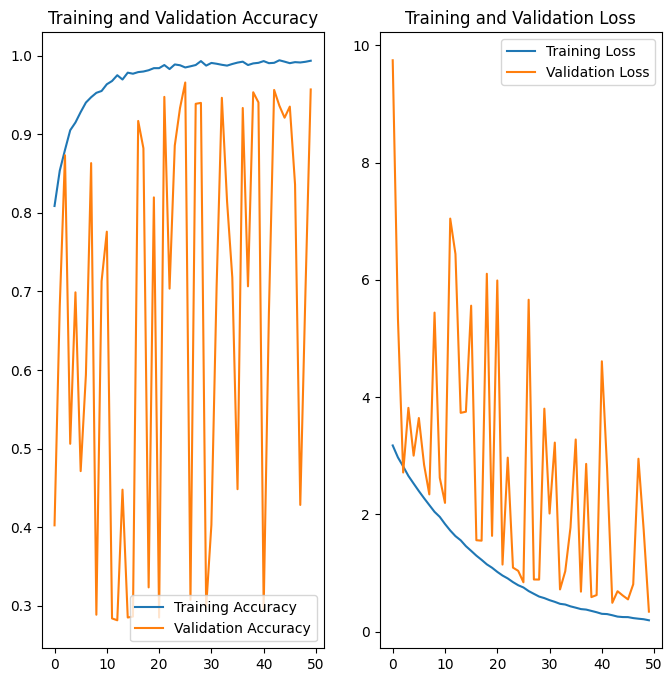

In [92]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [93]:
                                                                                # Step 1
modelGo.load_weights(model_file)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

54/54 [==============================] - 1s 12ms/step
Prediction completes.


In [94]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts, axis=1)
testout     = np.argmax(y_val_bin, axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                    output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 96.58%
                 precision    recall  f1-score   support

       arrowana     0.9045    0.9171    0.9108       217
     betta_fish     0.9672    0.9267    0.9465       191
common_goldfish     0.9790    0.9976    0.9882       421
         luohan     0.8913    0.8865    0.8889       185
         oranda     0.9971    0.9941    0.9956       683

       accuracy                         0.9658      1697
      macro avg     0.9478    0.9444    0.9460      1697
   weighted avg     0.9659    0.9658    0.9658      1697



In [97]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

fish_img = "validate/Screenshot 2022-09-08 210113.jpg"
#fish_img = "validate/0221faa8b79c4b2eb4dfee6f46912d74.jpg"
#fish_img = "validate/word-image.jpeg"
#fish_path = tf.keras.utils.get_file('Fish', origin=fish_url)

img = tf.keras.utils.load_img(
    fish_img, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
#img_array = np.array([img_array])

#saved_model = load_model('fish_model.h5')
saved_model = load_model(model_file)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

model.evaluate(img_array)

print(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step - loss: 0.1680 - accuracy: 0.0000e+00
[0. 0. 1. 0. 0.]
This image most likely belongs to common_goldfish with a 40.46 percent confidence.
